# Import Python Libraries

In [1]:
import numpy as np
import time
import os
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop

import matplotlib.pyplot as plt

Using TensorFlow backend.


# Load MNIST Datset

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
from keras.datasets import mnist

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype(np.float)
y_train = y_train.astype(np.float)
x_train = x_train/np.max(x_train)

The first four images of x_train and their own labels are in the following:


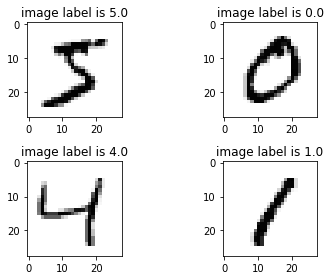

In [4]:
print("The first four images of x_train and their own labels are in the following:")
f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)
ax1.imshow(x_train[0], cmap='Greys',  interpolation='nearest')
ax1.set_title('image label is {}'.format(y_train[0]))
ax2.imshow(x_train[1], cmap='Greys',  interpolation='nearest')
ax2.set_title('image label is {}'.format(y_train[1]))
ax3.imshow(x_train[2], cmap='Greys',  interpolation='nearest')
ax3.set_title('image label is {}'.format(y_train[2]))
ax4.imshow(x_train[3], cmap='Greys',  interpolation='nearest')
ax4.set_title('image label is {}'.format(y_train[3]))
f.tight_layout()
plt.show()

# DCGAN class

In [5]:
class DCGAN(object):
    def __init__(self, img_rows=28, img_cols=28, channel=1):

        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channel = channel
        self.D = None   # discriminator
        self.G = None   # generator
        self.AM = None  # adversarial model
        self.DM = None  # discriminator model

    # (W−F+2P)/S+1 : larger than convoulution window: /2 else: keep
    def discriminator(self):
        if self.D:
            return self.D
        self.D = Sequential()
        
        # Input size: 28 x 28 x 1, depth = 1
        # Conv2D(<#out featuere map>,<filter size>,<stride>,<input>,<padding>)
        self.D.add(Conv2D(64, 5, strides=2, input_shape=(self.img_rows, self.img_cols, self.channel),    
                       padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(0.4))
        
        # size: 14 X 14 x 64
        self.D.add(Conv2D(128, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(0.4))

        # size: 7 x 7 x 128
        self.D.add(Conv2D(256, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(0.4))
        
        # size: 4 x 4 x 256
        self.D.add(Conv2D(512, 5, strides=1, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(0.4))

        # In_size: 4 x 4 x 512
        # Out: 1-dim probability
        self.D.add(Flatten())
        self.D.add(Dense(1))
        self.D.add(Activation('sigmoid'))
        self.D.summary()
        
        return self.D

    
    def generator(self):
        if self.G:
            return self.G
        self.G = Sequential()
        
        # In: 100
        # Out: dim x dim x depth --> dense output size = 7x7x256
        # Batchnormalization after Dense
        # Upsampling2D: shape*2
        # Conv2DTranspose: deepth/2
        self.G.add(Dense((7*7*256), input_shape=(100,)))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
        self.G.add(Reshape((7, 7, 256)))
        self.G.add(Dropout(0.4))
    
        # Each level after this:
        # In: dim x dim x depth
        # Out: 2*dim x 2*dim x depth/2
        
        # In 7 x 7 x 256
        # out: 14 x 14 x 128
        # process: 7 x 7 x 256 -(upsample)-> 14 x 14 x 256 -(convtranspose)-> 14 x 14 x 128
        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(128, 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
    
        # In: 14 x 14 x 128
        # Out:28 x 28 x 64
        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(64, 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        # In: 28 x 28 x 64
        # Out: 28 x 28 x 32
        self.G.add(Conv2DTranspose(32, 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        # Out: 28 x 28 x 1 grayscale image [0.0,1.0] per pix
        self.G.add(Conv2DTranspose(1, 5, padding='same'))
        self.G.add(Activation('sigmoid'))
        self.G.summary()

        return self.G

    def discriminator_model(self):
        if self.DM:
            return self.DM
        optimizer = RMSprop(lr=0.0002, decay=6e-8)
        self.DM = Sequential()
        self.DM.add(self.discriminator())
        self.DM.compile(loss='binary_crossentropy', optimizer=optimizer,
            metrics=['accuracy'])
        return self.DM

    def adversarial_model(self):
        if self.AM:
            return self.AM
        optimizer = RMSprop(lr=0.0001, decay=3e-8)
        self.AM = Sequential()
        self.AM.add(self.generator())
        self.AM.add(self.discriminator())
        self.AM.compile(loss='binary_crossentropy', optimizer=optimizer,
            metrics=['accuracy'])
        return self.AM

In [12]:
Img_dir = "./MINST_Images/"
if not os.path.exists(Img_dir):
    os.makedirs(Img_dir)

# DCGAN class

In [17]:
class MNIST_DCGAN(object):
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channel = 1

        self.x_train = input_data.read_data_sets("mnist", one_hot=True).train.images
        self.x_train = self.x_train.reshape(-1, self.img_rows, self.img_cols, 1).astype(np.float32)

        self.DCGAN = DCGAN()
        self.discriminator =  self.DCGAN.discriminator_model()
        self.adversarial = self.DCGAN.adversarial_model()
        self.generator = self.DCGAN.generator()

    def train(self, train_steps=2000, batch_size=256, save_interval=5):
        noise_input = None
        if save_interval>0:
            noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
        for i in range(train_steps):
            images_train = self.x_train[np.random.randint(0,
                self.x_train.shape[0], size=batch_size), :, :, :]
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            images_fake = self.generator.predict(noise)
            x = np.concatenate((images_train, images_fake))
            y = np.ones([2*batch_size, 1])
            y[batch_size:, :] = 0
            d_loss = self.discriminator.train_on_batch(x, y)

            y = np.ones([batch_size, 1])
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            a_loss = self.adversarial.train_on_batch(noise, y)
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
            print(log_mesg)
            if save_interval>0:
                if (i+1)%save_interval==0:
                    self.plot_images(save2file=True, samples=noise_input.shape[0], noise=noise_input, step=(i+1))

    def plot_images(self, save2file=False, fake=True, samples=16, noise=None, step=0):
        Img_dir = "./MINST_Images/"
        if not os.path.exists(Img_dir):
            os.makedirs(Img_dir)
        filename = 'mnist.png'
        if fake:
            if noise is None:
                noise = np.random.uniform(-1.0, 1.0, size=[samples, 100])
            else:
                filename = "mnist_%d.png" % step
            images = self.generator.predict(noise)
        else:
            i = np.random.randint(0, self.x_train.shape[0], samples)
            images = self.x_train[i, :, :, :]

        plt.figure(figsize=(10,10))
        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.img_rows, self.img_cols])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        if save2file:
            plt.savefig(Img_dir+filename)
            plt.close('all')
        else:
            plt.show()

# DCGAN train

In [20]:
mnist_dcgan = MNIST_DCGAN()
mnist_dcgan.train(train_steps=1000, batch_size=256, save_interval=50)

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_32 (Dropout)         (None

41: [D loss: 5.560041, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
42: [D loss: 1.210302, acc: 0.560547]  [A loss: 0.000004, acc: 1.000000]
43: [D loss: 0.050225, acc: 0.988281]  [A loss: 0.000200, acc: 1.000000]
44: [D loss: 0.050333, acc: 0.992188]  [A loss: 0.004671, acc: 1.000000]
45: [D loss: 0.194332, acc: 0.916016]  [A loss: 0.296316, acc: 0.878906]
46: [D loss: 7.253973, acc: 0.500000]  [A loss: 0.000001, acc: 1.000000]
47: [D loss: 3.452428, acc: 0.505859]  [A loss: 16.118101, acc: 0.000000]
48: [D loss: 6.582989, acc: 0.500000]  [A loss: 0.892385, acc: 0.765625]
49: [D loss: 7.588823, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
50: [D loss: 7.340280, acc: 0.500000]  [A loss: 0.000259, acc: 1.000000]
51: [D loss: 4.640446, acc: 0.501953]  [A loss: 16.118101, acc: 0.000000]
52: [D loss: 6.528356, acc: 0.500000]  [A loss: 8.946106, acc: 0.003906]
53: [D loss: 7.862472, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
54: [D loss: 7.879908, acc: 0.498047]  [A loss: 0

153: [D loss: 1.259800, acc: 0.501953]  [A loss: 5.764864, acc: 0.000000]
154: [D loss: 0.921888, acc: 0.562500]  [A loss: 0.032861, acc: 1.000000]
155: [D loss: 1.724062, acc: 0.500000]  [A loss: 1.384669, acc: 0.117188]
156: [D loss: 0.934639, acc: 0.513672]  [A loss: 3.728964, acc: 0.000000]
157: [D loss: 0.761112, acc: 0.542969]  [A loss: 0.776481, acc: 0.472656]
158: [D loss: 1.211694, acc: 0.511719]  [A loss: 6.881843, acc: 0.000000]
159: [D loss: 1.107727, acc: 0.529297]  [A loss: 0.018416, acc: 1.000000]
160: [D loss: 2.087956, acc: 0.500000]  [A loss: 0.888512, acc: 0.382812]
161: [D loss: 1.048052, acc: 0.511719]  [A loss: 4.038708, acc: 0.000000]
162: [D loss: 0.686349, acc: 0.621094]  [A loss: 0.364934, acc: 0.890625]
163: [D loss: 1.252784, acc: 0.507812]  [A loss: 4.995711, acc: 0.000000]
164: [D loss: 0.799382, acc: 0.642578]  [A loss: 0.071707, acc: 1.000000]
165: [D loss: 1.687503, acc: 0.500000]  [A loss: 2.449838, acc: 0.000000]
166: [D loss: 0.787348, acc: 0.535156]

264: [D loss: 1.671702, acc: 0.574219]  [A loss: 0.000333, acc: 1.000000]
265: [D loss: 4.966663, acc: 0.500000]  [A loss: 0.377504, acc: 0.839844]
266: [D loss: 1.802172, acc: 0.515625]  [A loss: 6.256768, acc: 0.000000]
267: [D loss: 0.896789, acc: 0.621094]  [A loss: 2.177916, acc: 0.156250]
268: [D loss: 2.265734, acc: 0.501953]  [A loss: 12.115791, acc: 0.000000]
269: [D loss: 1.804023, acc: 0.556641]  [A loss: 0.000089, acc: 1.000000]
270: [D loss: 6.135512, acc: 0.500000]  [A loss: 0.231359, acc: 0.898438]
271: [D loss: 2.047202, acc: 0.507812]  [A loss: 7.374921, acc: 0.000000]
272: [D loss: 0.959644, acc: 0.593750]  [A loss: 1.644363, acc: 0.285156]
273: [D loss: 2.839356, acc: 0.500000]  [A loss: 12.987770, acc: 0.000000]
274: [D loss: 2.272991, acc: 0.541016]  [A loss: 0.000073, acc: 1.000000]
275: [D loss: 6.956925, acc: 0.500000]  [A loss: 0.048383, acc: 0.992188]
276: [D loss: 2.855886, acc: 0.501953]  [A loss: 6.392017, acc: 0.000000]
277: [D loss: 1.550042, acc: 0.52929

375: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
376: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
377: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
378: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
379: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
380: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
381: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
382: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
383: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
384: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
385: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
386: [D loss: 7.953526, acc: 0.500000]  [A loss: 0.000124, acc: 1.000000]
387: [D loss: 7.955447, acc: 0.500000]  [A loss: 2.026796, acc: 0.753906]
388: [D loss: 7.971192, acc: 0.500000]

486: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
487: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
488: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
489: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
490: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
491: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
492: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
493: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
494: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
495: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
496: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
497: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
498: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
499: [D loss: 7.971192, acc: 0.500000]

597: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
598: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
599: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
600: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
601: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
602: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
603: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
604: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
605: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
606: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
607: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
608: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
609: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
610: [D loss: 7.971192, acc: 0.500000]

708: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
709: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
710: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
711: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
712: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
713: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
714: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
715: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
716: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
717: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
718: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
719: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
720: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
721: [D loss: 7.971192, acc: 0.500000]

819: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
820: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
821: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
822: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
823: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
824: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
825: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
826: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
827: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
828: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
829: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
830: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
831: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
832: [D loss: 7.971192, acc: 0.500000]

930: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
931: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
932: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
933: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
934: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
935: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
936: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
937: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
938: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
939: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
940: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
941: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
942: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
943: [D loss: 7.971192, acc: 0.500000]